In [ ]:
import pandas as pd
import numpy as np

path = "data/all_apps_wide_2026-01-28.csv"

df_managers = pd.read_csv(
    path,
    sep=",",
)

#1. participant._current_page_name == results -> remove non experiment rows
mask = df['participant._current_page_name'] == 'Results'
df = df[mask]

#2. create dict of column names to access them easier
cols = {
    'comprehension_attempts': 'intro.1.player.comprehension_attempts',
    'retailer_choice': 'intro.1.group.retailer_choice',
    'supplier_choice': 'intro.1.group.supplier_choice',
    'payoff': 'experiment.1.player.payoff',
    'profit': 'experiment.1.player.profit',
    'role': 'participant.role',
    'first_mover': 'session.first_mover_role'
}

#3. create column for total mistakes during comprehension check phase

def mistakes_per_comprehension_row(row):
    values = row.split(',')
    clean_values = [int(x.split(':')[1].strip().strip('}')) for x in values]
    corrected_values = [x-1 for x in clean_values]

    return sum(corrected_values)

df['defined.comprehension_mistakes'] = df[cols['comprehension_attempts']].apply(mistakes_per_comprehension_row)
cols['comprehension_mistakes'] = 'defined.comprehension_mistakes'

#4. create column for manager / employee distinction

df['defined.is_manager'] = df[cols['role']].str.contains('Manager', case=False)
cols['is_manager'] = 'defined.is_manager'

#5. create column to check for deal existence between two humans

df['defined.human_deal'] = df['experiment.1.player.price_accepted'].notna()
cols['human_deal'] = 'defined.human_deal'

#6. create column for first mover choice
df['defined.first_mover_choice'] = None

df.loc[df[cols['first_mover']] == 'Retailer Manager',
       'defined.first_mover_choice'] = df[cols['retailer_choice']]
df.loc[df[cols['first_mover']] == 'Supplier Manager',
       'defined.first_mover_choice'] = df[cols['supplier_choice']]

cols['first_mover_choice'] = 'defined.first_mover_choice'

#7. create column for second mover choice
df['defined.second_mover_choice'] = None

df.loc[df[cols['first_mover']] != 'Retailer Manager',
       'defined.second_mover_choice'] = df[cols['retailer_choice']]
df.loc[df[cols['first_mover']] != 'Supplier Manager',
       'defined.second_mover_choice'] = df[cols['supplier_choice']]

cols['second_mover_choice'] = 'defined.second_mover_choice'

#8. create column for choice of the specific manager in that row
df['defined.choice'] = None

df.loc[df[cols['role']] == 'Retailer Manager',
       'defined.choice'] = df[cols['retailer_choice']]
df.loc[df[cols['role']] == 'Supplier Manager',
       'defined.choice'] = df[cols['supplier_choice']]

cols['choice'] = 'defined.choice'

#9. ensure that retailer and supplier config flags differ: 1/0 or 0/1

for index, row in df.iterrows():
    if row['session.config.force_retailer_first'] == row['session.config.force_supplier_first']:
        raise Exception('session.config.force_retailer_first = session.config.force_supplier_first | Random Assignment')

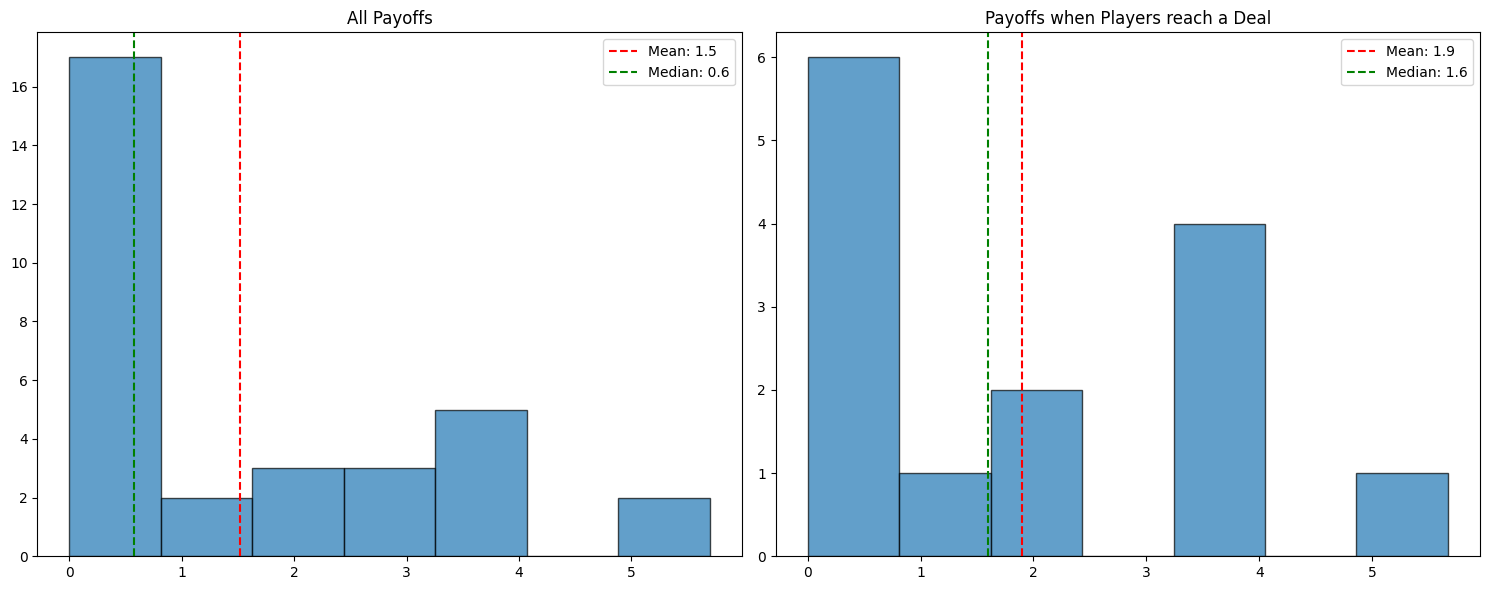

All payoffs:
 count    32.000000
mean      1.519687
std       1.796497
min       0.000000
25%       0.000000
50%       0.570000
75%       3.030000
max       5.700000
Name: experiment.1.player.payoff, dtype: float64

Human deals:
 count    14.000000
mean      1.902857
std       1.863650
min       0.000000
25%       0.210000
50%       1.595000
75%       3.282500
max       5.670000
Name: experiment.1.player.payoff, dtype: float64


In [2]:
import matplotlib.pyplot as plt
import numpy as np

payoff_col = df[cols['payoff']]
human_deal_mask = df[cols['human_deal']]
payoff_col_with_deal = payoff_col[human_deal_mask]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# All payoffs
ax1.hist(payoff_col, bins=7, edgecolor='black', alpha=0.7)
ax1.axvline(payoff_col.mean(), color='red', linestyle='--', 
            label=f'Mean: {payoff_col.mean():.1f}')
ax1.axvline(payoff_col.median(), color='green', linestyle='--', 
            label=f'Median: {payoff_col.median():.1f}')
ax1.set_title('All Payoffs')
ax1.legend()

# Payoffs when players reach a deal
ax2.hist(payoff_col_with_deal, bins=7, edgecolor='black', alpha=0.7)
ax2.axvline(payoff_col_with_deal.mean(), color='red', linestyle='--', 
            label=f'Mean: {payoff_col_with_deal.mean():.1f}')
ax2.axvline(payoff_col_with_deal.median(), color='green', linestyle='--', 
            label=f'Median: {payoff_col_with_deal.median():.1f}')
ax2.set_title('Payoffs when Players reach a Deal')
ax2.legend()

plt.tight_layout()
plt.show()

# Stats
print("All payoffs:\n", payoff_col.describe())
print("\nHuman deals:\n", payoff_col_with_deal.describe())


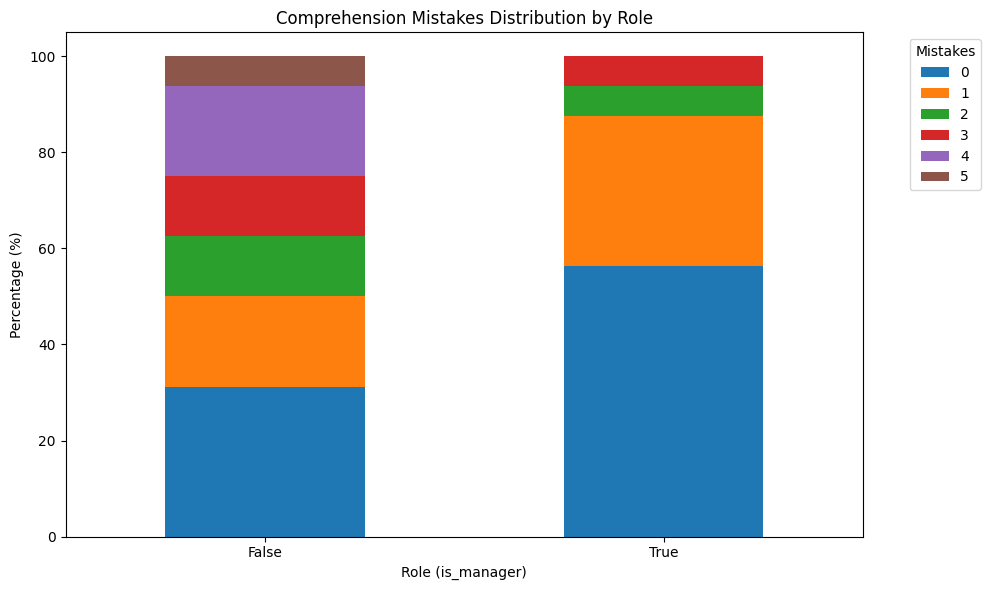

Stats by role:

                    count   mean       std  min  25%  50%   75%  max
defined.is_manager                                                  
False                16.0  1.875  1.746425  0.0  0.0  1.5  3.25  5.0
True                 16.0  0.625  0.885061  0.0  0.0  0.0  1.00  3.0

Raw counts:

defined.comprehension_mistakes  0  1  2  3  4  5
defined.is_manager                              
False                           5  3  2  2  3  1
True                            9  5  1  1  0  0


In [3]:
import matplotlib.pyplot as plt
import pandas as pd

mistakes_col = df[cols['comprehension_mistakes']]
role_col = df[cols['is_manager']]

# Stacked bar chart by role
ct = pd.crosstab(role_col, mistakes_col, normalize='index') * 100
ct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.ylabel('Percentage (%)')
plt.xlabel('Role (is_manager)')
plt.title('Comprehension Mistakes Distribution by Role')
plt.legend(title='Mistakes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Stats by role
print("Stats by role:\n")
print(mistakes_col.groupby(role_col).describe())
print("\nRaw counts:\n")
print(pd.crosstab(role_col, mistakes_col))


In [4]:
df.columns.tolist()

['participant.id_in_session',
 'participant.code',
 'participant.label',
 'participant._is_bot',
 'participant._index_in_pages',
 'participant._max_page_index',
 'participant._current_app_name',
 'participant._current_page_name',
 'participant.time_started_utc',
 'participant.visited',
 'participant.mturk_worker_id',
 'participant.mturk_assignment_id',
 'participant.payoff',
 'participant.role',
 'participant.choice',
 'session.code',
 'session.label',
 'session.mturk_HITId',
 'session.mturk_HITGroupId',
 'session.comment',
 'session.is_demo',
 'session.config.demand_min',
 'session.config.llm_user',
 'session.config.demand_max',
 'session.config.llm_temp',
 'session.config.llm_reader',
 'session.config.production_cost',
 'session.config.production_cost_high',
 'session.config.production_cost_low',
 'session.config.room',
 'session.config.llm_pass',
 'session.config.https://ollama2.src-automating.src.surf-hosted.nl',
 'session.config.https://ollama7.src-automating.src.surf-hosted.nl',


In [22]:
df_managers = df[df[cols['is_manager']]]

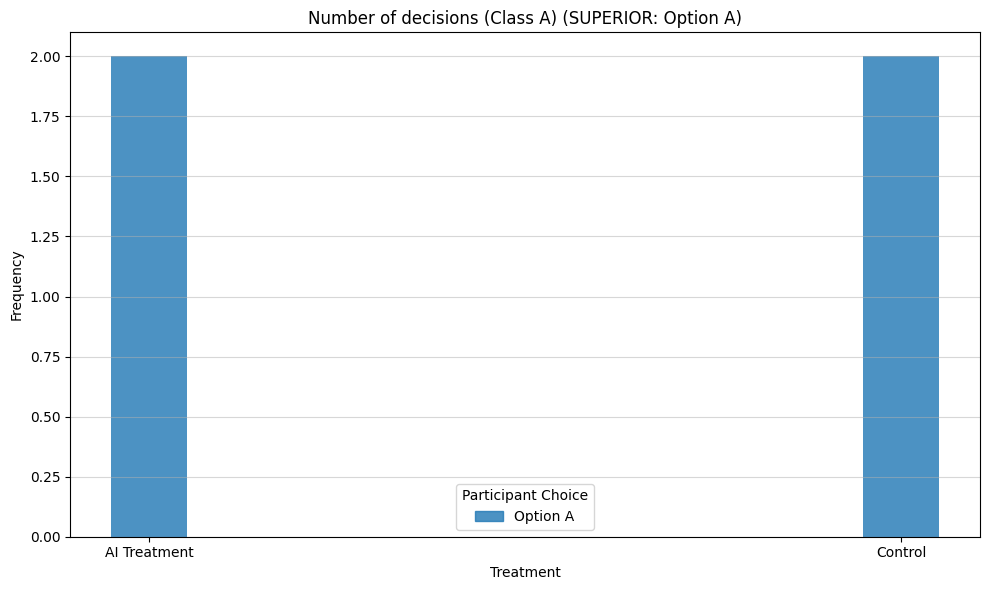

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter by class_a first, then by baseline
class_a_data = df_managers[df_managers['session.config.class_a'] == 1]

baseline_1 = class_a_data[class_a_data['session.config.baseline'] == 1][cols['second_mover_choice']]
baseline_0 = class_a_data[class_a_data['session.config.baseline'] == 0][cols['second_mover_choice']]

# Get value counts and align indices
baseline_1_counts = baseline_1.value_counts().sort_index()
baseline_0_counts = baseline_0.value_counts().sort_index()

# Get all unique choices across both conditions
all_choices = sorted(set(baseline_1_counts.index) | set(baseline_0_counts.index))

# Reindex both series to have the same index (fill missing with 0)
baseline_1_counts = baseline_1_counts.reindex(all_choices, fill_value=0)
baseline_0_counts = baseline_0_counts.reindex(all_choices, fill_value=0)

# Create figure
plt.figure(figsize=(10, 6))

# Use tab10 colormap for normal colors
colors = plt.cm.tab10(np.arange(len(all_choices)))

# Set up positions - two groups closer together
x_baseline_0 = 0
x_baseline_1 = 0.8
width = 0.08

# Plot bars for each choice
for i, choice in enumerate(all_choices):
    plt.bar(x_baseline_0 + i * width, baseline_0_counts[choice], width, 
            color=colors[i], alpha=0.8)
    plt.bar(x_baseline_1 + i * width, baseline_1_counts[choice], width, 
            color=colors[i], alpha=0.8)

# Create custom legend with relabeled choices
choice_labels = {
    'AJ': 'Option B (Potentially AI)',
    'HS': 'Option A'
}
handles = [plt.Rectangle((0,0),1,1, color=colors[i], alpha=0.8) for i in range(len(all_choices))]
labels = [choice_labels.get(choice, f'Choice {choice}') for choice in all_choices]
plt.legend(handles, labels, title='Participant Choice')

# Add labels and title
plt.xlabel('Treatment')
plt.ylabel('Frequency')
plt.title('Number of decisions (Class A) (SUPERIOR: Option A)')
plt.xticks([x_baseline_0 + (len(all_choices)-1)*width/2, x_baseline_1 + (len(all_choices)-1)*width/2], 
           ['AI Treatment', 'Control'])
plt.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

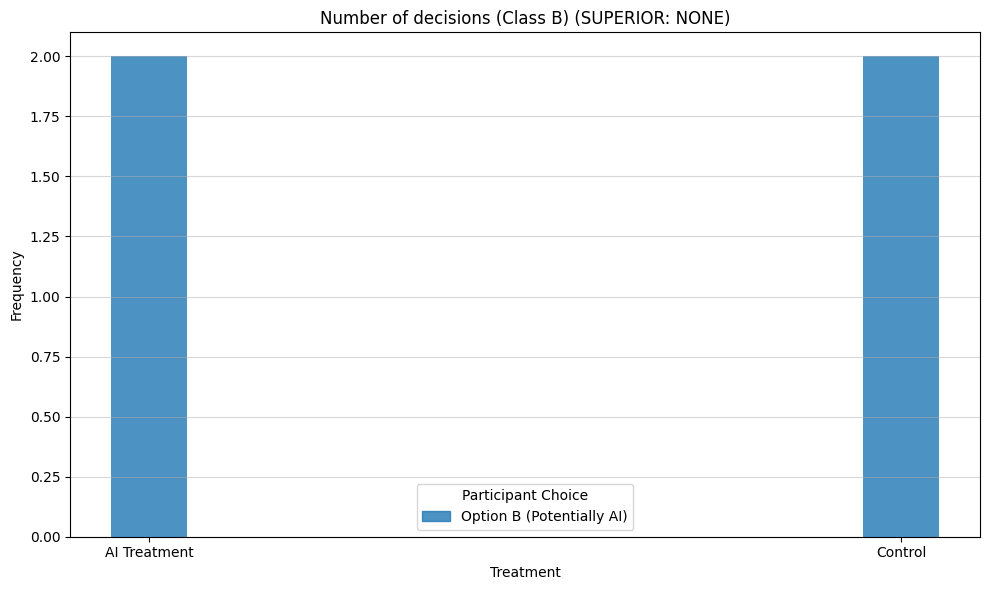

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter by class_b first, then by baseline
class_b_data = df_managers[df_managers['session.config.class_b'] == 1]

baseline_1 = class_b_data[class_b_data['session.config.baseline'] == 1][cols['second_mover_choice']]
baseline_0 = class_b_data[class_b_data['session.config.baseline'] == 0][cols['second_mover_choice']]

# Get value counts and align indices
baseline_1_counts = baseline_1.value_counts().sort_index()
baseline_0_counts = baseline_0.value_counts().sort_index()

# Get all unique choices across both conditions
all_choices = sorted(set(baseline_1_counts.index) | set(baseline_0_counts.index))

# Reindex both series to have the same index (fill missing with 0)
baseline_1_counts = baseline_1_counts.reindex(all_choices, fill_value=0)
baseline_0_counts = baseline_0_counts.reindex(all_choices, fill_value=0)

# Create figure
plt.figure(figsize=(10, 6))

# Use tab10 colormap for normal colors
colors = plt.cm.tab10(np.arange(len(all_choices)))

# Set up positions - two groups closer together
x_baseline_0 = 0
x_baseline_1 = 0.8
width = 0.08

# Plot bars for each choice
for i, choice in enumerate(all_choices):
    plt.bar(x_baseline_0 + i * width, baseline_0_counts[choice], width, 
            color=colors[i], alpha=0.8)
    plt.bar(x_baseline_1 + i * width, baseline_1_counts[choice], width, 
            color=colors[i], alpha=0.8)

# Create custom legend with relabeled choices
choice_labels = {
    'AJ': 'Option B (May be AI)',
    'HS': 'Option A'
}
handles = [plt.Rectangle((0,0),1,1, color=colors[i], alpha=0.8) for i in range(len(all_choices))]
labels = [choice_labels.get(choice, f'Choice {choice}') for choice in all_choices]
plt.legend(handles, labels, title='Participant Choice')

# Add labels and title
plt.xlabel('Treatment')
plt.ylabel('Frequency')
plt.title('Number of decisions (Class B) (SUPERIOR: NONE)')
plt.xticks([x_baseline_0 + (len(all_choices)-1)*width/2, x_baseline_1 + (len(all_choices)-1)*width/2], 
           ['AI Treatment', 'Control'])
plt.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

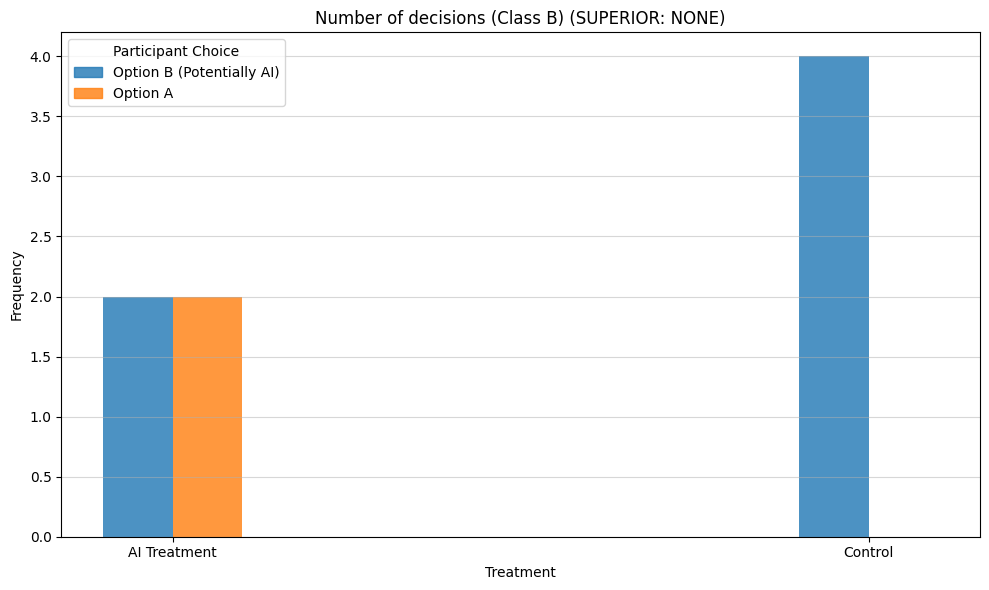

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter by class_c first, then by baseline
class_c_data = df_managers[df_managers['session.config.class_c'] == 1]

baseline_1 = class_c_data[class_c_data['session.config.baseline'] == 1][cols['second_mover_choice']]
baseline_0 = class_c_data[class_c_data['session.config.baseline'] == 0][cols['second_mover_choice']]

# Get value counts and align indices
baseline_1_counts = baseline_1.value_counts().sort_index()
baseline_0_counts = baseline_0.value_counts().sort_index()

# Get all unique choices across both conditions
all_choices = sorted(set(baseline_1_counts.index) | set(baseline_0_counts.index))

# Reindex both series to have the same index (fill missing with 0)
baseline_1_counts = baseline_1_counts.reindex(all_choices, fill_value=0)
baseline_0_counts = baseline_0_counts.reindex(all_choices, fill_value=0)

# Create figure
plt.figure(figsize=(10, 6))

# Use tab10 colormap for normal colors
colors = plt.cm.tab10(np.arange(len(all_choices)))

# Set up positions - two groups closer together
x_baseline_0 = 0
x_baseline_1 = 0.8
width = 0.08

# Plot bars for each choice
for i, choice in enumerate(all_choices):
    plt.bar(x_baseline_0 + i * width, baseline_0_counts[choice], width, 
            color=colors[i], alpha=0.8)
    plt.bar(x_baseline_1 + i * width, baseline_1_counts[choice], width, 
            color=colors[i], alpha=0.8)

# Create custom legend with relabeled choices
choice_labels = {
    'AJ': 'Option B (Potentially AI)',
    'HS': 'Option A'
}
handles = [plt.Rectangle((0,0),1,1, color=colors[i], alpha=0.8) for i in range(len(all_choices))]
labels = [choice_labels.get(choice, f'Choice {choice}') for choice in all_choices]
plt.legend(handles, labels, title='Participant Choice')

# Add labels and title
plt.xlabel('Treatment')
plt.ylabel('Frequency')
plt.title('Number of decisions (Class B) (SUPERIOR: NONE)')
plt.xticks([x_baseline_0 + (len(all_choices)-1)*width/2, x_baseline_1 + (len(all_choices)-1)*width/2], 
           ['AI Treatment', 'Control'])
plt.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()